In [3]:
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as pg
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import namedtuple
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn import metrics
import lightgbm as lgb

plt.style.use('fivethirtyeight')

pio.templates.default = "plotly_dark"


In [4]:
df = pl.read_csv('ibm_telco_customer_churn.csv')

In [5]:
churn_fraction = df['Churn Value'].mean()

px.histogram(x=df['Churn Label'], color=df['Churn Label'], 
             title=f'Churn Fraction = {churn_fraction*100:.2f}%',)


In [6]:
px.histogram(x=df['Churn Reason']).update_xaxes(categoryorder='total descending').show()
df = df.filter(pl.col("Churn Reason") != 'Deceased')


In [7]:
text = df['Churn Reason'].drop_nulls().str.concat()[0]
word_cloud = WordCloud(collocations = False, width=1920, height=1080).generate(text)
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [9]:
def make_binned_averages(data, feature, target, bw, bmin=0, bmax=0):    
    s = data[feature].drop_nans().drop_nulls()

    if bmax == 0:
        bmax = max(s) 

    bins = np.arange(bmin, bmax + bw, step=bw)
    n, b = np.histogram(s, bins=bins)
    m = (b[1:] + b[:-1]) / 2

    h = data.to_pandas()

    h['binrange'] = pd.cut(h[feature], bins=bins)

    g = h.groupby('binrange')[target].mean()

    ntup = namedtuple("BinnedData", ["r", "means", "feature", "target", "bins"])

    return ntup(m, g, data[feature], data[target], bins)

In [10]:
temporal_features = ["Monthly Charges", "Tenure Months", "Total Charges"]
target = 'Churn Value'

f0d = make_binned_averages(df, temporal_features[0], target, bw=5, bmin=15, bmax=120)
f1d = make_binned_averages(df, temporal_features[1], target, bw=2, bmin=-0.5)

fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# maybe this should be relative to show diffs
sns.lineplot(x=f0d.r, y=f0d.means, ax=axes[0, 0])
axes[0, 0].set_xlabel(temporal_features[0])
axes[0, 0].set_ylabel(f'Average {target}')
axes[0, 0].set_ylim([0, max(f0d.means) * (1.05)])
sns.histplot(x=f0d.feature, hue=f0d.target, bins=f0d.bins, multiple='stack', ax=axes[0, 1])

sns.lineplot(x=f1d.r, y=f1d.means, ax=axes[1, 0])
axes[1, 0].set_xlabel(temporal_features[1])
axes[1, 0].set_ylabel(f'Average {target}')
sns.histplot(x=f1d.feature, hue=f1d.target, bins=f1d.bins, multiple='stack', ax=axes[1, 1])
plt.show()

In [ ]:
s = df.select(['City', 'Churn Value']).groupby('City').mean().filter(pl.col('Churn Value') > 0).sort(by='Churn Value')

# sns.lineplot(x=s['City'], y=s['Churn Value'])
# plt.show()
px.line(x=s['City'], y=s['Churn Value'])

In [59]:
binary_features = ["Senior Citizen", "Partner", "Dependents", "Paperless Billing", "Phone Service"]

online_features = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',]

target = 'Churn Value'

paf = df.to_pandas()

h = paf.loc[:,binary_features + online_features].apply(lambda gdf: gdf.value_counts()).T.fillna(0)
h[['Yes', 'No', 'No internet service']].plot(kind='bar', stacked=True, rot=330)

fig = plt.gcf()
fig.set_size_inches((16, 10))

ax = fig.get_axes()[0]
for label in ax.get_xticklabels():
    label.set_ha('left')
    label.set_rotation_mode('anchor')

In [60]:
binary_features = ["Senior Citizen", "Partner", "Dependents", "Paperless Billing", "Phone Service"]

online_features = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',]

target = 'Churn Value'
paf = df.to_pandas()
hf = paf.loc[:,binary_features].apply(lambda gdf: paf.groupby(gdf)[target].mean()).fillna(0).T


hf.sort_values(by="Yes", ascending=False, inplace=True)
hf[['Yes', 'No']].plot(kind='bar', rot=330, ylabel='Average Churn Value')


fig = plt.gcf()
fig.set_size_inches((16, 10))

ax = fig.get_axes()[0]
for label in ax.get_xticklabels():
    label.set_ha('left')
    label.set_rotation_mode('anchor')

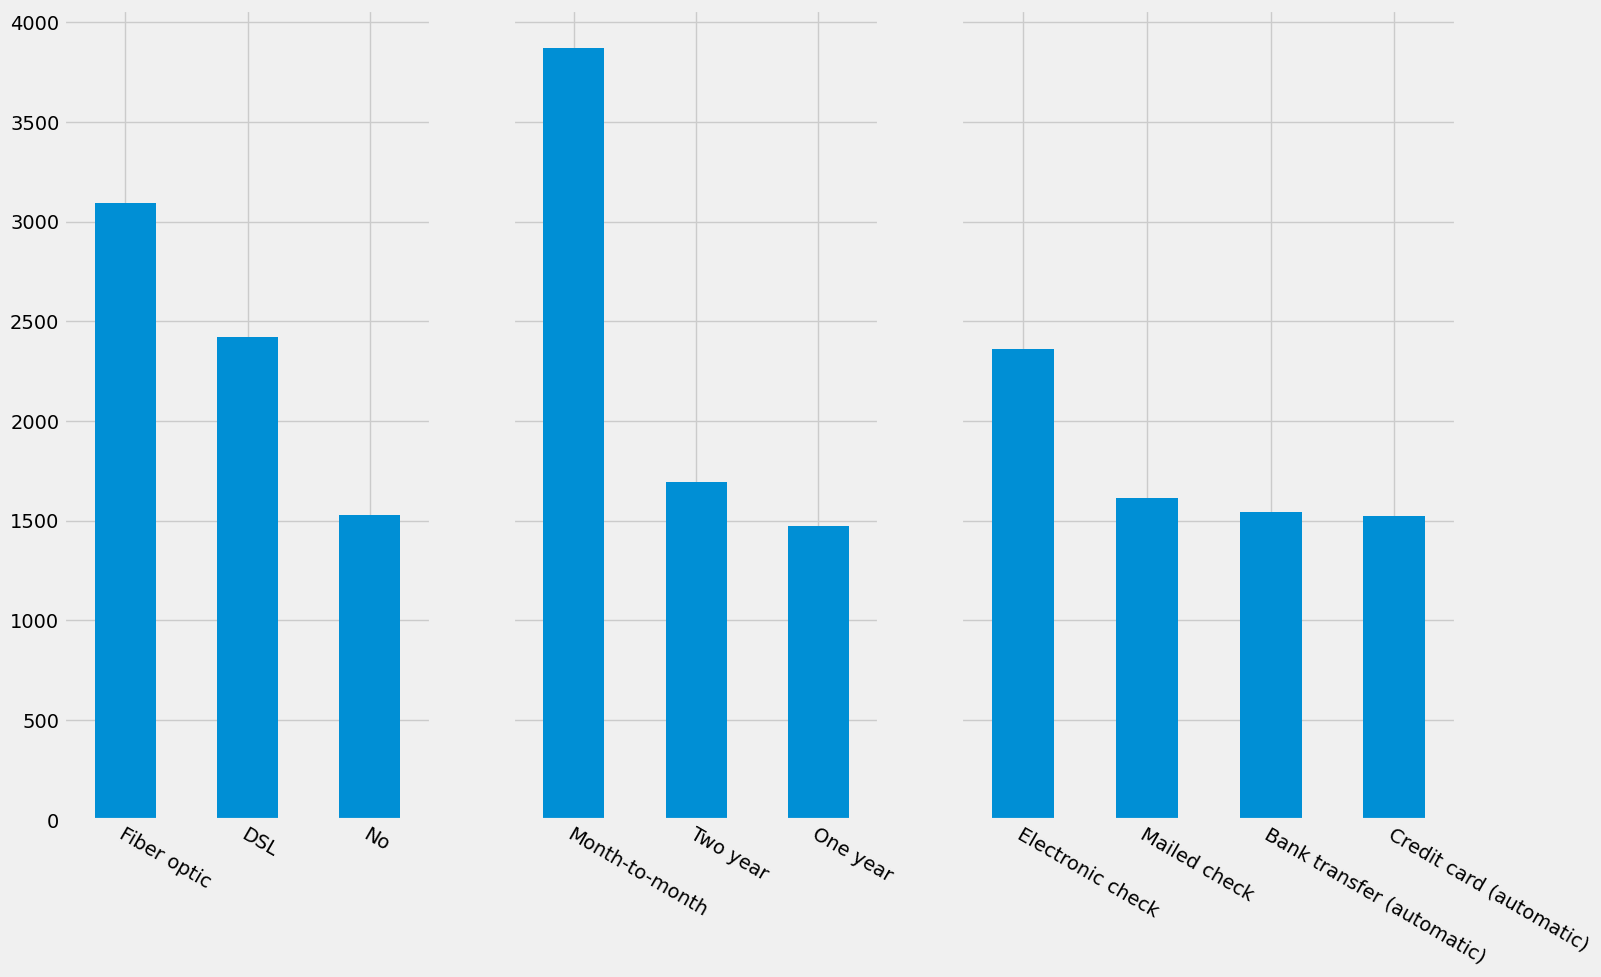

In [61]:
multiopt_features = ['Internet Service', 'Contract', 'Payment Method']

fig, axes = plt.subplots(1, 3, figsize=(16, 10), sharey=True,  gridspec_kw={'width_ratios': [1, 1, 1.35]})

for k, v in enumerate(multiopt_features):
    paf.loc[:, v].value_counts().plot(kind='bar', ax=axes[k], rot=330)
    
    for label in axes[k].get_xticklabels():
        label.set_ha('left')
        label.set_rotation_mode('anchor')

plt.show()

In [ ]:
multiopt_features = ['Internet Service', 'Contract', 'Payment Method']


lst_df = []
for feature in multiopt_features:
    g = paf.loc[:,[feature, 'Churn Value']].groupby(feature).mean()
    g['feature'] = [feature] * len(g)
    lst_df.append(g)

cf = pd.concat(lst_df)

fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True, 
                         gridspec_kw={'height_ratios': [1, 1, 1.35]})

for k, v in enumerate(multiopt_features):
    cf[cf['feature']==v].plot(kind='barh', ax=axes[k], width=0.4, legend=False, ylabel=v)


fig.tight_layout()
axes[2].set_xlabel('Average Churn Value')


Text(0.5, 40.583333333333286, 'Average Churn Value')

In [ ]:

to_drop = ['Churn Reason', 'Churn Label', 'Latitude', 'Longitude', 'Zip Code', 'Lat Long', 'CustomerID', 'Count', 'Country', 'State', 'Gender', 'City']

nf = df.drop(to_drop)
pnf = nf.to_pandas()


# scaler = MinMaxScaler()

# pnf['Tenure Months'] = scaler.fit_transform(pnf['Tenure Months'].values.reshape(-1, 1))
# pnf['Monthly Charges'] = scaler.fit_transform(pnf['Monthly Charges'].values.reshape(-1, 1))
# pnf['Total Charges'] = scaler.fit_transform(pnf['Total Charges'].values.reshape(-1, 1))

categorical_features = [col for col in pnf.columns if pnf[col].dtype==object]

ef = pd.get_dummies(pnf, columns=categorical_features, drop_first = True).dropna()

x = ef.drop(columns=['Churn Value'])
y = ef['Churn Value']

pca = PCA(n_components=3)

r = pca.fit_transform(x)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

px.scatter_matrix(r, labels=labels, dimensions=range(3), color=ef['CLTV']).update_traces(diagonal_visible=False)

In [ ]:
kmeans = KMeans(n_clusters=5, n_init='auto')
xc = kmeans.fit_predict(x)

label_cmap = {0 : 'r', 1 : 'g', 2 : 'b', 3 : 'c', 4 : 'm'}
label_color = [label_cmap[i] for i in xc]

sns.scatterplot(x=r[:,0], y=r[:,1], color= label_color, alpha=0.1)


<Axes: >

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)


# TODO: make function that facilitates cross validation for the gradient boosters. 

XGBClassification metrics

Training Accuracy 1.0
Test Accuracy     0.92
Recall            0.85
Precision         0.82
ROC AUC           0.89


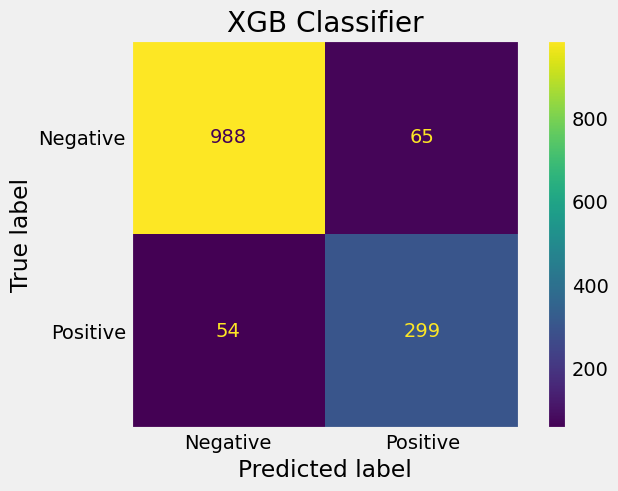

In [ ]:
xgb_model = XGBClassifier()
xgb_model.fit(x_train, y_train)

xgb_train_pred = xgb_model.predict(x_train)
xgb_acc_train = accuracy_score(xgb_train_pred, y_train)

xgb_test_pred = xgb_model.predict(x_test)
xgb_acc_test = accuracy_score(xgb_test_pred, y_test)


# TODO: put these in a function that generates a nice table for the performance of the classifier.
xgb_recall = recall_score(y_test,xgb_test_pred)
xgb_precision = precision_score(y_test, xgb_test_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_test_pred)
print("XGBClassification metrics\n")
print("Training Accuracy", round(xgb_acc_train, 2))
print("Test Accuracy    ", round(xgb_acc_test,2))
print("Recall           ", round(xgb_recall,2))
print("Precision        ", round(xgb_precision,2))
print("ROC AUC          ", round(xgb_roc_auc, 2))

    # ConfusionMatrixDisplay.from_predictions(
    #     y_test, y_pred, display_labels=labels_strs, normalize="true", ax=axes[1], cmap="Blues"
    # )

confusion_matrix = metrics.confusion_matrix(y_test, xgb_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['Negative', 'Positive'],)

cm_display.plot()

plt.grid(False)
plt.title('XGB Classifier')
plt.show()


LGBClassification metrics

Training Accuracy 1.0
Test Accuracy     0.93
Recall            0.88
Precision         0.83
ROC AUC           0.91


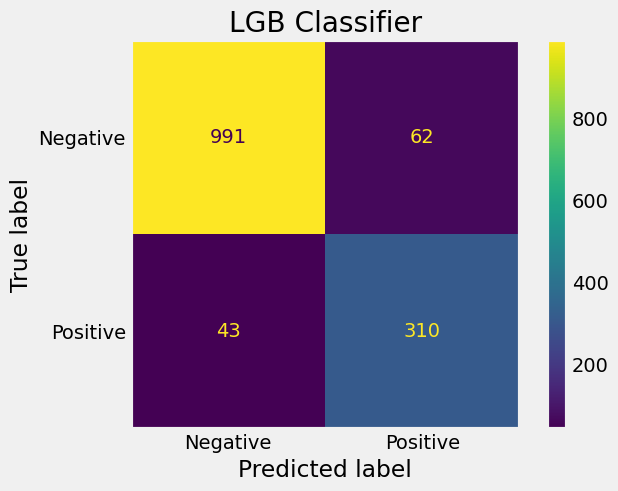

In [ ]:
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(x_train, y_train)

lgb_train_pred = lgb_model.predict(x_train)
lgb_acc_train = accuracy_score(lgb_train_pred, y_train)

lgb_test_pred = lgb_model.predict(x_test)
lgb_acc_test = accuracy_score(lgb_test_pred, y_test)



lgb_recall = recall_score(y_test,lgb_test_pred)
lgb_precision = precision_score(y_test, lgb_test_pred)
lgb_roc_auc = roc_auc_score(y_test, lgb_test_pred)
print("LGBClassification metrics\n")
print("Training Accuracy", round(lgb_acc_train, 2))
print("Test Accuracy    ", round(lgb_acc_test,2))
print("Recall           ", round(lgb_recall,2))
print("Precision        ", round(lgb_precision,2))
print("ROC AUC          ", round(lgb_roc_auc, 2))



confusion_matrix = metrics.confusion_matrix(y_test, lgb_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['Negative', 'Positive'])
cm_display.plot()
plt.grid(False)
plt.title('LGB Classifier')
plt.show()




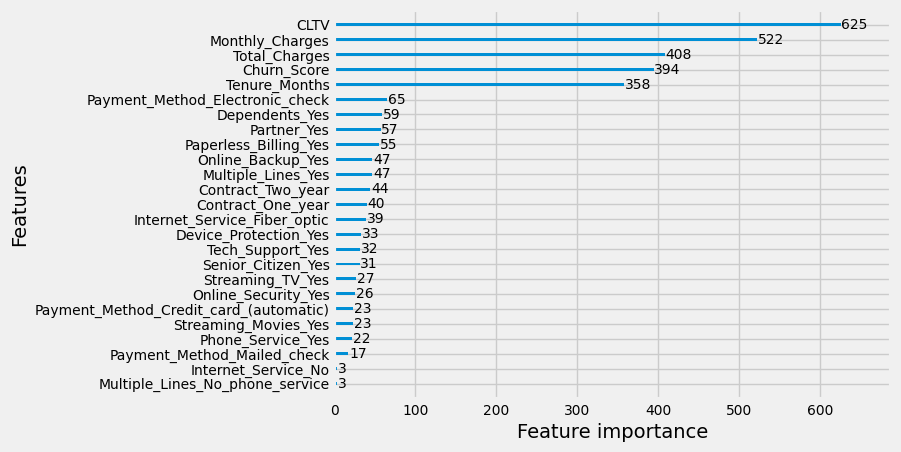

In [ ]:
lgb.plot_importance(lgb_model)
plt.title("")


plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.size'] = 10
plt.show()